In [1]:
import json
import os
import pickle
import psycopg2
import pandas as pd
import sqlalchemy

import sys
sys.path.append("..")
from connect_db import db_connection

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
username='ovasarhelyi'

In [4]:
cred_location = '/mnt/data/'+username+'/TPT_tourism/connect_db/data_creds_redshift.json.nogit'
db = db_connection.DBConnection(cred_location)

# Number of customers by country

In [5]:
query="""select 
mcc, 
count(distinct customer_id) as num_unique_cus
from
tuscany.vodafone
group by mcc
order by num_unique_cus desc"""

In [6]:
number_of_cus_per_country= db.sql_query_to_data_frame(query)

In [7]:
number_of_cus_per_country.head()

,mcc,num_unique_cus
0,262.0,1263660
1,208.0,904955
2,234.0,850541
3,204.0,820920
4,310.0,667993


In [8]:
number_of_cus_per_country['num_unique_cus'].sum()

9631906

In [9]:
# read the country codes in
mcc=pd.read_csv('/mnt/data/shared/mcc-mnc-table.csv')

In [10]:
mcc=pd.read_csv('/mnt/data/shared/mcc-mnc-table.csv')

In [11]:
mcc.head()

,MCC,MCC (int),MNC,MNC (int),ISO,Country,Country Code,Network
0,289,649,88.0,2191,ge,Abkhazia,7.0,A-Mobile
1,289,649,68.0,1679,ge,Abkhazia,7.0,A-Mobile
2,289,649,67.0,1663,ge,Abkhazia,7.0,Aquafon
3,412,1042,88.0,2191,af,Afghanistan,93.0,Afghan Telecom Corp. (AT)
4,412,1042,80.0,2063,af,Afghanistan,93.0,Afghan Telecom Corp. (AT)


In [12]:
mcc_country=mcc.drop_duplicates("MCC", keep='first')[['MCC', 'Country']]

In [13]:
mcc_country['mcc']=mcc_country['MCC'].astype(int)

In [14]:
def clean_guam(row):
    if row['Country']=='Guam':
        return 'United States'
    else:
        return row['Country']

In [15]:
mcc_country['Country']=mcc_country.apply(clean_guam,1)

In [16]:
number_of_cus_country=number_of_cus_per_country.set_index('mcc').join(mcc_country.set_index('mcc'))[['Country','num_unique_cus']]

In [17]:
k=number_of_cus_country.groupby('Country').sum().sort_values('num_unique_cus', ascending=False)

Text(0,0.5,'')

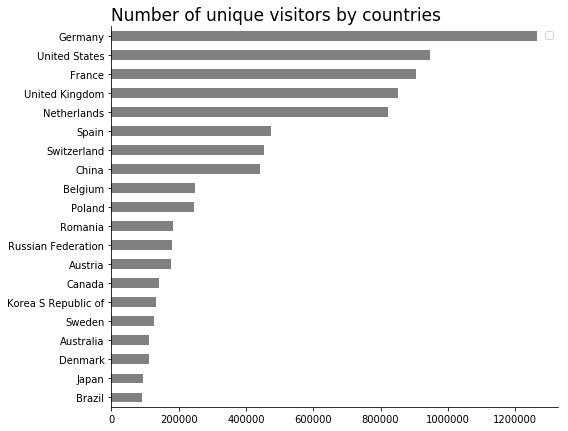

In [18]:
plt.rc("figure", figsize=(8, 7))
k[:20].sort_values('num_unique_cus').plot(kind='barh', color='grey')
sns.despine()
plt.title('Number of unique visitors by countries', loc='left', size=17)
plt.legend("")
plt.ylabel("")

In [19]:
import seaborn as sns

In [20]:
number_of_cus_country=number_of_cus_per_country.set_index('mcc').join(mcc_country.set_index('mcc'))[['Country','num_unique_cus']]

In [21]:
k=number_of_cus_country.groupby('Country').sum().sort_values('num_unique_cus', ascending=False)

In [22]:
k.head()

,num_unique_cus
Country,
Germany,1263660
United States,947387
France,904955
United Kingdom,850542
Netherlands,820920


# How much time people spend in Italy?

In [23]:
time_dur="""select distinct customer_id, mcc, min(time_stamp) as starttime, max(time_stamp) as endtime,
		max(time_stamp)-min(time_stamp) as duration 
        from tpt.tuscany.vodafone group by customer_id, mcc
		order by max(time_stamp)-min(time_stamp) desc"""

In [24]:
duration_mcc= db.sql_query_to_data_frame(time_dur)

In [25]:
duration_mcc.head()

,customer_id,mcc,starttime,endtime,duration
0,FA465CF6D38576B9C1CAF3D6EAC9C71E,214.0,2017-05-01,2018-02-28 23:59:00,303 days 23:59:00
1,332A5DB2D755D91B1A2921414F588DE1,204.0,2017-05-01,2018-02-28 23:59:00,303 days 23:59:00
2,0D516A34C1776E28F50BAA5F96296503,204.0,2017-05-01,2018-02-28 23:59:00,303 days 23:59:00
3,86718CBFDD4C07DF4BFC80AD08A42448,310.0,2017-05-01,2018-02-28 23:59:00,303 days 23:59:00
4,671DE64B97A3DE7FA089E7614648D5C2,262.0,2017-05-01,2018-02-28 23:59:00,303 days 23:59:00


In [26]:
import numpy as np

In [27]:
duration_mcc['hours']=duration_mcc['duration']/pd.Timedelta('1 hour')

In [28]:
duration_mcc['days']=duration_mcc['duration']/pd.Timedelta('1 day')

In [29]:
len(duration_mcc[duration_mcc['duration']==pd.Timedelta(0)])/len(duration_mcc)

0.09627170364827066

In [30]:
no_zero=duration_mcc[duration_mcc['duration']!=pd.Timedelta(0)]

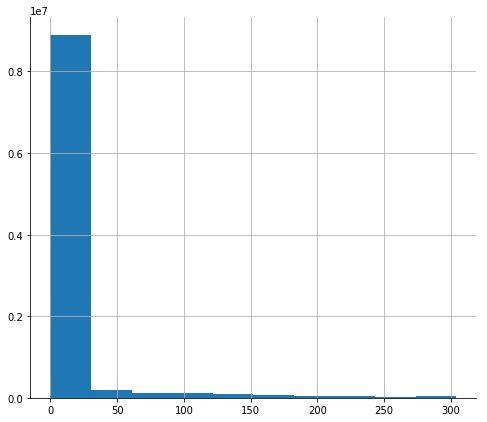

In [31]:
duration_mcc['days'].hist()
sns.despine()

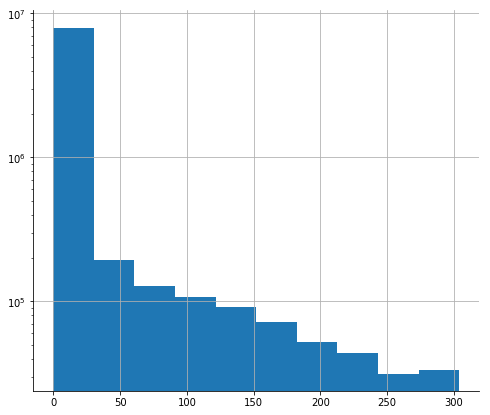

In [32]:
no_zero['days'].hist(log=True)
sns.despine()

In [33]:
ratio_of_people=[]
for i in range(0,24*30):
    ratio_of_people.append(len(duration_mcc[duration_mcc['hours']<i])/len(duration_mcc))

In [34]:
len(ratio_of_people)

720

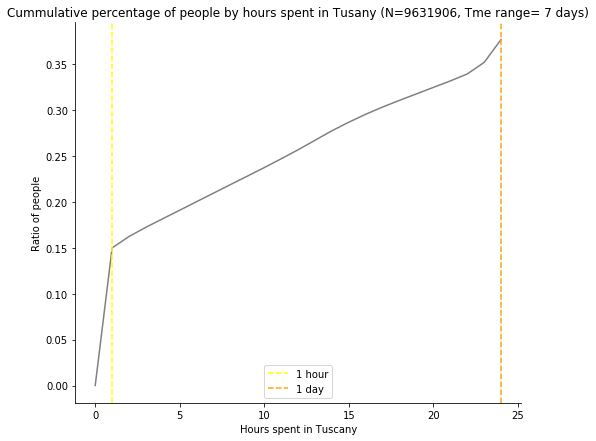

In [35]:
plt.plot(range(0,25),ratio_of_people[:25], color="grey")
plt.xlabel('Hours spent in Tuscany')
plt.ylabel("Ratio of people")
plt.title("Cummulative percentage of people by hours spent in Tusany (N=9631906, Tme range= 7 days)")
plt.axvline(1, linestyle='--', color="yellow", label='1 hour')
plt.axvline(24, linestyle='--', color="orange", label='1 day')
#plt.axvline(24*2, linestyle='--', color="red", label='2 days')
#plt.axvline(24*3, linestyle='--', color="green", label='3 days')

plt.legend()
sns.despine()

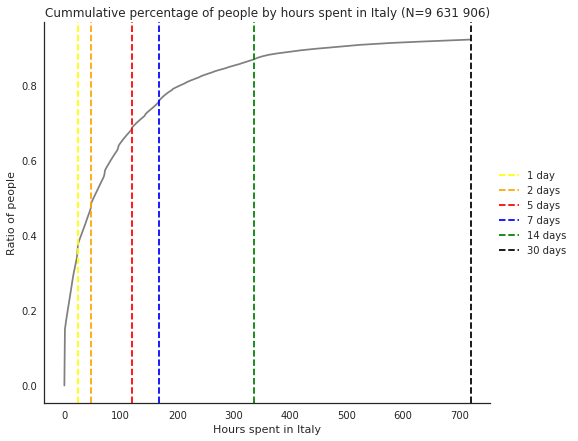

In [83]:
plt.plot(range(0,24*30),ratio_of_people, color="grey")
plt.xlabel('Hours spent in Italy')
plt.ylabel("Ratio of people")
plt.title("Cummulative percentage of people by hours spent in Italy (N=9 631 906)")
#plt.axvline(1, linestyle='--', color="yellow", label='1 hour')
plt.axvline(24, linestyle='--', color="yellow", label='1 day')
plt.axvline(24*2, linestyle='--', color="orange", label='2 days')
plt.axvline(24*5, linestyle='--', color="red", label='5 days')
plt.axvline(24*7, linestyle='--', color="blue", label='7 days')
plt.axvline(24*14, linestyle='--', color="green", label='14 days')
plt.axvline(24*30, linestyle='--', color="black", label='30 days')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()

In [37]:
hours_cum=pd.DataFrame(ratio_of_people)

In [38]:
hours_cum[:14*24+1].tail()

,0
332,0.866842
333,0.867341
334,0.867891
335,0.868535
336,0.869404


# ONLY TUSCANY LOCATIONS

In [43]:
time_dur="""select distinct customer_id, mcc, min(time_stamp) as starttime, 
max(time_stamp) as endtime, max(time_stamp)-min(time_stamp) as duration 
from tpt.tuscany.vodafone vod
inner join tpt.tuscany.location_dictionary locs
on locs.location_id=vod.location_id
and locs.region = '9'
group by customer_id, mcc 
order by max(time_stamp)-min(time_stamp) desc"""

In [44]:
duration_tusc= db.sql_query_to_data_frame(time_dur)

In [45]:
duration_tusc['hours']=duration_tusc['duration']/pd.Timedelta('1 hour')

In [46]:
len(duration_tusc), len(duration_mcc)

(9588321, 9631906)

In [ ]:
duration_tusc['hours'].hist(log=True)

In [79]:
ratio_of_people_tusc=[]
for i in range(0,24*30):
    ratio_of_people_tusc.append(len(duration_tusc[duration_tusc['hours']<i])/len(duration_tusc))

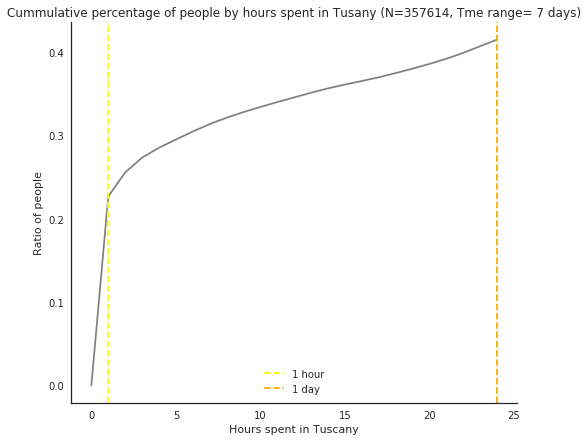

In [80]:
plt.plot(range(0,25),ratio_of_people_tusc[:25], color="grey")
plt.xlabel('Hours spent in Tuscany')
plt.ylabel("Ratio of people")
plt.title("Cummulative percentage of people by hours spent in Tusany (N=357614, Tme range= 7 days)")
plt.axvline(1, linestyle='--', color="yellow", label='1 hour')
plt.axvline(24, linestyle='--', color="orange", label='1 day')

plt.legend()
sns.despine()

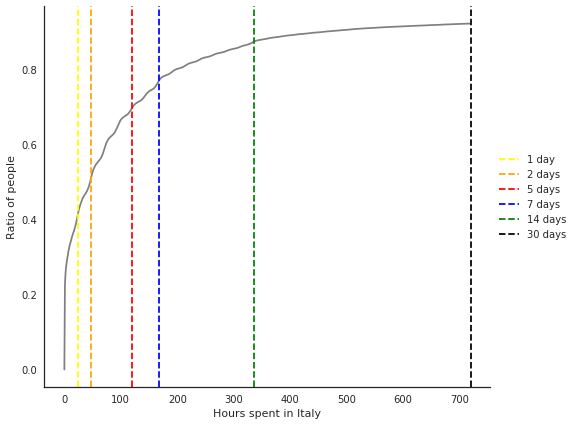

In [81]:
plt.plot(range(0,24*30),ratio_of_people_tusc, color="grey")
plt.xlabel('Hours spent in Italy')
plt.ylabel("Ratio of people")
#plt.title("Cummulative percentage of people by hours spent in Tusany (N=9 631 906)")
plt.axvline(24, linestyle='--', color="yellow", label='1 day')
plt.axvline(24*2, linestyle='--', color="orange", label='2 days')
plt.axvline(24*5, linestyle='--', color="red", label='5 days')
plt.axvline(24*7, linestyle='--', color="blue", label='7 days')
plt.axvline(24*14, linestyle='--', color="green", label='14 days')
plt.axvline(24*30, linestyle='--', color="black", label='30 days')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()

# Italy and Toscany

In [51]:
tusc_it_dur=duration_mcc.set_index("customer_id").join(duration_tusc.set_index("customer_id"), rsuffix='_tusc')

In [52]:
#tusc_it_dur

In [53]:
tusc_it_dur['tusc_ratio']=tusc_it_dur['hours_tusc']/tusc_it_dur['hours']

In [54]:
tusc_it_dur['tusc_ratio'].describe()

count    8.673682e+06
mean     7.923223e-01
std      3.266790e-01
min      0.000000e+00
25%      7.357478e-01
50%      9.731914e-01
75%      1.000000e+00
max      1.000000e+00
Name: tusc_ratio, dtype: float64

Text(0,1,'Ratio of time spent in Tuscnay over Italy')

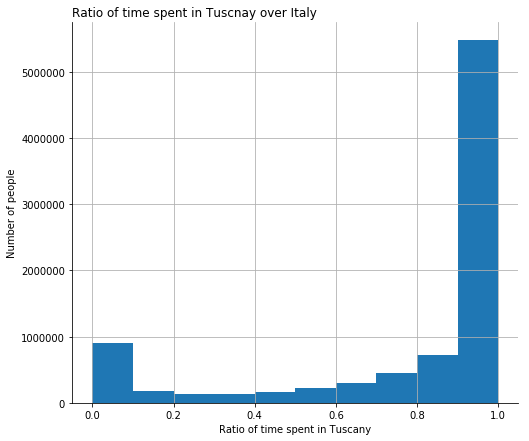

In [55]:
tusc_it_dur['tusc_ratio'].hist()
sns.despine()
plt.ylabel("Number of people")
plt.xlabel("Ratio of time spent in Tuscany")
plt.title("Ratio of time spent in Tuscnay over Italy", loc='left')


In [56]:
mcc_country['mcc']=mcc_country["MCC"].astype(float)

In [57]:
tusc_it_dur2=pd.merge(tusc_it_dur,mcc_country, right_index=True, on='mcc')

In [58]:
tusc_it_aggr=tusc_it_dur2[['Country', 'hours', 'hours_tusc', 'tusc_ratio']].groupby('Country').mean().join(k).join(tusc_it_dur2[['Country', 'hours', 'hours_tusc', 'tusc_ratio']].groupby('Country').sum(), rsuffix='_sum')

In [59]:
tusc_it_aggr.sort_values('hours_tusc_sum', ascending=False)[:20]

,hours,hours_tusc,tusc_ratio,num_unique_cus,hours_sum,hours_tusc_sum,tusc_ratio_sum
Country,,,,,,,
Netherlands,597.233627,591.285973,0.826282,820920,4.902810e+08,4.842283e+08,610593.264104
Germany,281.826485,277.208105,0.841633,1263660,3.561329e+08,3.482213e+08,987698.817321
France,376.935521,371.659952,0.780679,904955,3.411097e+08,3.344631e+08,659544.574241
United Kingdom,267.583236,265.018537,0.838839,850542,2.275908e+08,2.237658e+08,591704.566010
Switzerland,475.686255,470.193771,0.813032,451990,2.150054e+08,2.115397e+08,332521.125274
United States,190.046971,183.782975,0.815542,947387,1.800480e+08,1.734070e+08,700276.087310
Romania,615.851881,608.767963,0.733165,182251,1.122396e+08,1.108262e+08,122657.002827
Spain,236.290648,231.416012,0.801170,475530,1.123633e+08,1.091120e+08,326511.066839
Belgium,344.058314,338.885027,0.820867,248075,8.535227e+07,8.371782e+07,180334.599328


# Data Stories

### Only Tuscany
- Daily trip
- Long weekend 2-3 days
- Holiday (max 1 week) 

### Countries:
- Netherlands, Germany, US, France, UK, Germany, China, Russian Federation

In [61]:
def create_trippers(row):
    if 5<row['hours_tusc']<=24:
        return '1 - day '
    elif 25<row['hours_tusc']<=72:
        return '2 - 3 days'
    elif 72<row['hours_tusc'] < 6*24:
        return '4 - 5 days'
    elif 6*24 <row['hours_tusc'] < 10*24:
        return '6 - 8 days'
    elif 10*24 <row['hours_tusc']:
        return '10+ days'

In [62]:
len(tusc_it_dur2)

9630472

In [63]:
tusc_it_dur2['trip_type']=tusc_it_dur2.apply(create_trippers,1)

In [64]:
tusc_it_dur2['trip_type'].value_counts().sort_index()

2 - 3 days      1647167
4 - 5 days      1324470
1 - day         1148437
14+ days        1131935
6 - 8 days       601292
11 - 14 days     416773
9 - 11 days      258622
Name: trip_type, dtype: int64

In [65]:
countries=['Netherlands', 'Germany', 'United States', "France", "United Kingdom"]

In [66]:
def create_filter(row):
    if row['Country'] in countries:
        return 1
    else:
        return 0

In [67]:
tusc_it_dur2['needed']=tusc_it_dur2.apply(create_filter,1)

KeyboardInterrupt: 

In [ ]:
filtered_trips=tusc_it_dur2[tusc_it_dur2['needed']==1]

In [ ]:
top_countries=pd.crosstab(filtered_trips['Country'], filtered_trips['trip_type']).apply(lambda x: x / x.sum()).T

In [ ]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]

In [ ]:
sns.set_palette(sns.xkcd_palette(colors))

In [ ]:
top_countries.T.sort_values('1 - day tripper').T.sort_index(ascending=False)

In [ ]:
top_countries.T.sort_values('1 - day tripper').T.sort_index(ascending=False).plot(kind='barh', stacked=True)
sns.despine()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('')